# Similaridade de projetos - engenharia de features

Issue: [#244](https://github.com/lappis-unb/salic-ml/issues/244)

## Objetivos

Documentar a Engenharia de Features para Similaridade de projetos. A similaridade aqui é em termos de estrutura: itens, produtos, segmentos e áreas.

### Features

- Segmento
- Area
- Produtos culturais. Considerar apenas idProduto != 0, pois idProduto são itens de "administração de projeto" como: refeição, hospedagem, passagem aérea, postagem, contador, combustível, salário

pronac = '143251'

**Considerando os produtos**

1 - produtos

2 - produtos, segmento

3 - produtos, area, segmento

É importante considerar que se os segmentos são iguais, a probabilidade das áreas serem iguais é quase 1 (`(s - 1) / s`, onde `s = numero_de_segmentos`)

**Considerando os itens**

1 - conjunto de itens (id de itens)

2 - conjunto de itens, segmento

3 - conjunto de itens, área, segmento


### Algoritmos

1 - [Jaccard index](https://en.wikipedia.org/wiki/Jaccard_index)

2 - Jaccard index com pesos)

---
## Preparação

**Dataset sql**

`projects_similarity.sql`

Breve descrição de quais dados serão lidos e utilizados. A partir daqui, todas as seções devem ser iniciadas por uma barra horizontal (3 hífens, conforme a linha 1 desta célula), seguido de um header 2 (##) com o nome da seção e então a descrição da seção. As demais subseções devem ser declaradas com um header 4 (####) seguido de uma descrição, que é opcional.

Abaixo é mostrado um exemplo de utilização da seção de preparação.

#### Importando módulos e definindo constantes

In [1]:
%pylab inline
%load_ext autoreload
%autoreload 2

import scipy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 

from core.utils.read_csv import read_csv

Populating the interactive namespace from numpy and matplotlib


#### Carregando e mostrando dataset a ser utilizado ao longo do estudo

In [2]:
planilha_name = 'planilha_orcamentaria_similaridade.csv'
df = read_csv(planilha_name)
df = df[df['idProduto'] != 0]
display(df.dtypes)
df.head()

idPronac                int64
PRONAC                  int64
idPlanilhaAprovacao     int64
Item                   object
idPlanilhaItens         int64
idArea                  int64
Area                   object
idSegmento             object
Segmento               object
idProduto               int64
Produto                object
DataProjeto            object
dtype: object

,idPronac,PRONAC,idPlanilhaAprovacao,Item,idPlanilhaItens,idArea,Area,idSegmento,Segmento,idProduto,Produto,DataProjeto
5,133870,110667,138377,Banner/faixa adesiva/faixa de lona/saia de pal...,2743,1,Artes Cênicas,11,Teatro,132,Manutenção de Instituição Cultural,2011-01-25 08:55:48
6,133870,110667,138378,Mídia impressa,178,1,Artes Cênicas,11,Teatro,132,Manutenção de Instituição Cultural,2011-01-25 08:55:48
15,133870,110667,138368,"Seguro (pessoas, obras e equipamentos - especi...",201,1,Artes Cênicas,11,Teatro,132,Manutenção de Instituição Cultural,2011-01-25 08:55:48
19,135253,112030,204990,Coordenação geral,3677,4,Artes Visuais,41,Plásticas,100,Fotografia - Aquisição / Exposição / Pesquisa,2011-03-11 11:38:12
24,112234,91102,72720,Faixas,176,7,Artes Integradas,71,Artes Integradas,113,Festa Popular,2009-05-06 10:32:53


### Extraindo features de produto

**Features**:

- idSegmento

- idArea

- produtos

In [3]:
PRODUCT_COLUMNS = ['PRONAC', 'idPronac', 'idSegmento', 'idArea', 'idProduto', 'idPlanilhaItens']
df_products = df[PRODUCT_COLUMNS]

display(df_products.head())

,PRONAC,idPronac,idSegmento,idArea,idProduto,idPlanilhaItens
5,110667,133870,11,1,132,2743
6,110667,133870,11,1,132,178
15,110667,133870,11,1,132,201
19,112030,135253,41,4,100,3677
24,91102,112234,71,7,113,176


In [4]:
products_group = df_products.groupby(['PRONAC'])

for pronac, group in products_group:
    id_segmento = group.iloc[0]['idSegmento']
    id_area = group.iloc[0]['idArea']
    id_pronac = group.iloc[0]['idPronac']
    products_unique = group.idProduto.unique()
    products = group.idProduto.values
    
    print('PRONAC = {}'.format(pronac))
    print('idPronac = {}'.format(id_pronac))
    print('id_segmento = {}'.format(id_segmento))
    print('id_area = {}'.format(id_area))
    print('products_unique = {}'.format(products_unique))
    print('products = {}'.format(products))

    
    break

PRONAC = 90105
idPronac = 111218
id_segmento = 11
id_area = 1
products_unique = [19]
products = [19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19
 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19
 19 19 19 19 19 19 19]


### Segmentos mais comuns

In [5]:
popular_segments = df[['PRONAC', 'idSegmento', 'idArea']].groupby(['PRONAC', 'idSegmento']).count()
popular_segments = popular_segments.groupby('idSegmento').count().sort_values(by='idArea', ascending=False)
display(popular_segments.head())

,idArea
idSegmento,
11,9793
31,4551
33,4338
4B,2659
12,2415


# Distribuição do número de produtos por projeto

A média do número de produtos culturais é de 2.5 (ignorando produtos do tipo `Administração do Proeto`, `idProduto=0`), portanto utilizar a similaridade de Jaccard apenas nestas features pode enviesar os resultados: muitos projetos serão muito parecidos.

count    41616.000000
mean         1.548299
std          0.956948
min          1.000000
25%          1.000000
50%          1.000000
75%          2.000000
max         15.000000
Name: idProduto, dtype: float64

Text(0, 0.5, 'Número de projetos')

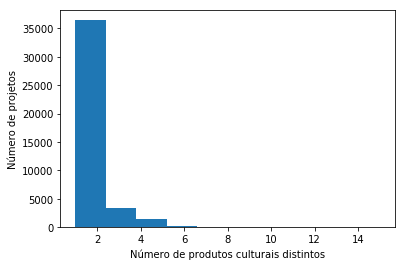

In [6]:
nunique_products = df[['PRONAC', 'idProduto']].groupby('PRONAC').nunique()
display(nunique_products['idProduto'].describe())
plt.hist(nunique_products.idProduto.values)
plt.xlabel('Número de produtos culturais distintos')
plt.ylabel('Número de projetos')

# Definindo e testando uma função de similaridade

### Features:
    - área do projeto
    - segmento do projeto
    - lista de produtos culturais (!= 0) do projeto

### Função de similaridade:
    - Jaccard index nas features acima

**Extraindo features de um pronac**

In [7]:
def get_products_features(pronac):
    group = products_group.get_group(pronac)
    id_segmento = group.iloc[0]['idSegmento']
    id_area = group.iloc[0]['idArea']
    products = group.idProduto.unique()
    features = {
        'id_segmento': [id_segmento],
        'id_area': [id_area],
        'products': list(products),
    }
    return features

display(get_products_features(138478))

{'id_segmento': ['4B'],
 'id_area': [4],
 'products': [121, 62, 50, 2, 16, 115, 81, 11, 27, 3, 67, 38, 8]}

**Implementando o Jaccard Index**

In [8]:
def jaccard_collections_similarity(a, b):
    '''Assumes that all sets in a are disjoint, as well as all sets in b'''
    assert isinstance(a, list)
    assert isinstance(b, list)
    assert len(a) == len(b)

    intersects = [np.intersect1d(a[i], b[i]).size for i in range(len(a))]
    unions = [np.union1d(a[i], b[i]).size for i in range(len(a))]
    return sum(intersects) / sum(unions)

def jaccard_similarity(a, b):
    assert isinstance(a, list)
    assert isinstance(b, list)
    
    intesect_size = np.intersect1d(a, b).size
    union_size = np.union1d(a, b).size
    return intesect_size / union_size

def simple_similarity(a, b):
    return 1 if a == b else 0


'''Exemplos de teste'''
display(jaccard_collections_similarity([[1, 2], [3, 5, 7]], [[2], [5, 7]]))
display(jaccard_similarity([1, 2, 5], [5, 2]))
display(simple_similarity(5, 5))

0.6

0.6666666666666666

1

**Calculando a similaridade entre 2 projetos**

In [9]:
def pronacs_similarity(pronac1, pronac2):
    features = [list(get_products_features(pronac).values()) for pronac in [pronac1, pronac2]]
    sim = jaccard_collections_similarity(*features)
    return sim

def debug_similarity(pronac1, pronac2):
    sim = pronacs_similarity(pronac1, pronac2)
    features1 = list(get_products_features(pronac1).values())
    features2 = list(get_products_features(pronac2).values())

    print('features1 = {}'.format(features1))
    print('features2 = {}'.format(features2))
    print('sim(pronac1, pronac2) = {}'.format(sim))
    
pronac1 = 110526
pronac2 = 112112
debug_similarity(pronac1, pronac2)

features1 = [['11'], [1], [19, 121, 2, 1]]
features2 = [['11'], [1], [19, 115, 12, 1, 50]]
sim(pronac1, pronac2) = 0.4444444444444444


In [10]:
def get_pronac_items(pronac):
    return list(df[df['PRONAC'] == pronac].idPlanilhaItens.unique())

In [11]:
pronac1 = 90105
pronac2 = 158191
debug_similarity(pronac1, pronac2)
jaccard_similarity(get_pronac_items(pronac1), get_pronac_items(pronac2))

features1 = [['11'], [1], [19]]
features2 = [['11'], [1], [19]]
sim(pronac1, pronac2) = 1.0


0.06451612903225806

### Um problema com as features (segmento, area, produtos)

Para estas features, a similaridade entre os pronac `90105` e `158191` é de `1.0`, valor máximo. Entretanto, a similaridade de Jaccard do seus conjuntos de itens é de `0.065`, um valor muitas vezes menor. Deveria estes projetos serem considerados muito similares?

As células abaixo presenta a planilha orçamentária destes dois PRONAC para fins de comparação subjetiva.

In [12]:
display(df[df['PRONAC'] == 90105])

,idPronac,PRONAC,idPlanilhaAprovacao,Item,idPlanilhaItens,idArea,Area,idSegmento,Segmento,idProduto,Produto,DataProjeto
223,111218,90105,115046,Transporte Local / Locação de Automóvel / Comb...,134,1,Artes Cênicas,11,Teatro,19,Espetáculo de Artes Cênicas,2009-02-18 09:09:27
224,111218,90105,115032,Músicos / Intérpretes,27,1,Artes Cênicas,11,Teatro,19,Espetáculo de Artes Cênicas,2009-02-18 09:09:27
245,111218,90105,115045,Diárias,1120,1,Artes Cênicas,11,Teatro,19,Espetáculo de Artes Cênicas,2009-02-18 09:09:27
354,111218,90105,115035,Bailarinos,2605,1,Artes Cênicas,11,Teatro,19,Espetáculo de Artes Cênicas,2009-02-18 09:09:27
550,111218,90105,115036,Figurantes,63,1,Artes Cênicas,11,Teatro,19,Espetáculo de Artes Cênicas,2009-02-18 09:09:27
565,111218,90105,115056,Confecção de ingressos,144,1,Artes Cênicas,11,Teatro,19,Espetáculo de Artes Cênicas,2009-02-18 09:09:27
643,111218,90105,115007,Tradutor e adaptador,12,1,Artes Cênicas,11,Teatro,19,Espetáculo de Artes Cênicas,2009-02-18 09:09:27
651,111218,90105,115057,Mídia impressa,178,1,Artes Cênicas,11,Teatro,19,Espetáculo de Artes Cênicas,2009-02-18 09:09:27
977,111218,90105,115013,Locação de sala para ensaios,2620,1,Artes Cênicas,11,Teatro,19,Espetáculo de Artes Cênicas,2009-02-18 09:09:27
996,111218,90105,115055,Folders,150,1,Artes Cênicas,11,Teatro,19,Espetáculo de Artes Cênicas,2009-02-18 09:09:27


In [13]:
display(df[df['PRONAC'] == 158191])

,idPronac,PRONAC,idPlanilhaAprovacao,Item,idPlanilhaItens,idArea,Area,idSegmento,Segmento,idProduto,Produto,DataProjeto
1716805,198298,158191,1717642,Operador de som,77,1,Artes Cênicas,11,Teatro,19,Espetáculo de Artes Cênicas,2015-09-28 15:30:24
1717820,198298,158191,1717637,Diretor geral,3617,1,Artes Cênicas,11,Teatro,19,Espetáculo de Artes Cênicas,2015-09-28 15:30:24
1717903,198298,158191,1717636,Roteirista,1002,1,Artes Cênicas,11,Teatro,19,Espetáculo de Artes Cênicas,2015-09-28 15:30:24
1717904,198298,158191,1717645,Cartaz,1219,1,Artes Cênicas,11,Teatro,19,Espetáculo de Artes Cênicas,2015-09-28 15:30:24
1717915,198298,158191,1717644,Assessor de imprensa,142,1,Artes Cênicas,11,Teatro,19,Espetáculo de Artes Cênicas,2015-09-28 15:30:24
1718482,198298,158191,1717633,Figurino,17,1,Artes Cênicas,11,Teatro,19,Espetáculo de Artes Cênicas,2015-09-28 15:30:24
1718483,198298,158191,1717635,Ensaios,2502,1,Artes Cênicas,11,Teatro,19,Espetáculo de Artes Cênicas,2015-09-28 15:30:24
1718662,198298,158191,1717643,Fotógrafo Still,1069,1,Artes Cênicas,11,Teatro,19,Espetáculo de Artes Cênicas,2015-09-28 15:30:24
1719943,198298,158191,1717649,Editoração Eletrônica,109,1,Artes Cênicas,11,Teatro,19,Espetáculo de Artes Cênicas,2015-09-28 15:30:24
1720359,198298,158191,1717634,Cenografia/material/confecção,3953,1,Artes Cênicas,11,Teatro,19,Espetáculo de Artes Cênicas,2015-09-28 15:30:24


**Procurando por pronacs que possuem o mesmo conjunto de produtos**

Esta célula serve apenas para achar pronacs para comparação subjetiva.

In [14]:
def find_pronacs_equal_products():
    artes = df[df['idSegmento'] == '11'][['PRONAC', 'idProduto']]
    nunique = artes.groupby('PRONAC').nunique().sort_values('idProduto')
    for i in range(len(nunique.index)):
        pronac1 = nunique.index[i]
        products1 = artes[artes['PRONAC'] == pronac1].idProduto.unique()

        for j in range(i + 1, len(nunique.index)):
            pronac2 = nunique.index[j]
            products2 = artes[artes['PRONAC'] == pronac2].idProduto.unique()

            if products1 == products2:
                print('pronac1 = {}'.format(pronac1))
                print('pronac2 = {}'.format(pronac2))
                return
            
find_pronacs_equal_products()

pronac1 = 90105
pronac2 = 158191


# Definindo e testando uma função de similaridade

A comparação anterior, com as features (área, segmento, produtos) apresentou uma limitação: estas features podem ser exatamente iguais entre dois projetos comparados, mas os itens utilizados entre estes dois projetos serem bastante diferentes. Portanto, vamos testar uma análise onde consideramos também o conjunto dos itens da planilha.

### Features:
    - área do projeto
    - segmento do projeto
    - lista de produtos culturais (!= 0) do projeto
    - lista de itens orçamentários (produto != 0) do projeto

### Função de similaridade:
    - Jaccard index nas features acima

**Filtrando as features de um pronac**

In [15]:
def get_products_items_features(pronac):
    group = products_group.get_group(pronac)
    id_segmento = group.iloc[0]['idSegmento']
    id_area = group.iloc[0]['idArea']
    products = group.idProduto.unique()
    items = group.idPlanilhaItens.unique()
    features = {
        'id_segmento': [id_segmento],
        'id_area': [id_area],
        'products': sorted(list(products)),
        'items': sorted(list(items)),
    }
    return features

print(get_products_items_features(110667))

{'id_segmento': ['11'], 'id_area': [1], 'products': [132], 'items': [53, 88, 129, 134, 144, 150, 178, 179, 201, 1119, 1129, 2357, 2574, 2611, 2726, 2743, 3097, 3235, 3546, 3650, 3677, 3740, 3745, 4882]}


In [16]:
def pronacs_similarity(pronac1, pronac2):
    features = [list(get_products_items_features(pronac).values()) for pronac in [pronac1, pronac2]]
    sim = jaccard_collections_similarity(*features)
    return sim

def debug_similarity(pronac1, pronac2):
    sim = pronacs_similarity(pronac1, pronac2)
    features1 = list(get_products_items_features(pronac1).values())
    features2 = list(get_products_items_features(pronac2).values())

    print('features1 = {}'.format(features1))
    print('features2 = {}'.format(features2))
    print('sim(pronac1, pronac2) = {}'.format(sim))
    
pronac1 = 90105
pronac2 = 158191
debug_similarity(pronac1, pronac2)

features1 = [['11'], [1], [19], [12, 22, 23, 24, 27, 40, 49, 53, 57, 61, 62, 63, 66, 67, 68, 71, 72, 73, 74, 75, 81, 83, 85, 117, 118, 134, 142, 143, 144, 150, 178, 179, 1002, 1037, 1050, 1120, 1219, 2605, 2611, 2620, 2631, 2632, 2633, 2634, 2639, 2667, 2695, 2715]]
features2 = [['11'], [1], [19], [17, 57, 77, 78, 109, 142, 160, 1002, 1043, 1069, 1172, 1219, 2502, 2743, 2768, 3589, 3617, 3953]]
sim(pronac1, pronac2) = 0.1076923076923077


### Análise do teste com as features (segmento, area, produtos, itens)

Adicionando a feature da lista de itens, a similaridade foi de `1.0` para `0.11`, entre os pronac `90105` e `158191`. A similaridade abaixou, como o esperado.

É importante observar que cada elemento das features `segmento, àrea, produtos` possuem o mesmo peso do que um elemento da feature `lista de itens`. Porém, na média, o tamanho da `lista de itens` é muito maior do que a `lista de produtos`, assim também como é muito maior do que a `lista de àrea ou segmento` (ambas possuem tamanho=1). Portanto, uma melhoria possível para esta função é dar pesos diferentes para estas features.

# Definindo e testando uma função de similaridade

O objetivo agora é pesos as features `segmento, àrea, lista de produtos, lista de itens`.

O Jaccard Index na sua versão pura não dá peso aos elementos dos conjuntos comparados. Porém podemos tentar dar peso as features e aproveitar a ideia do Jaccard Index.

### Features:
    - área do projeto
    - segmento do projeto
    - lista de produtos culturais (!= 0) do projeto
    - lista de itens orçamentários (produto != 0) do projeto

### Função de similaridade:
  
Seja `sim(p1, p2)` a função que calcule a similaridade entre os projetos `p1, p2`.

```
sim(p1, p2) = a * jaccard(area_p1, area_p2) +
              s * jaccard(segmento_p1, segmento_p2) +
              i * jaccard(itens_p1, itens_p2) +
              p * jaccard(produtos_p1, produtos_p2)
```

Note que é possível normalizar a função acima, pois com certeza ela está no limite `[0, sum(a, s, i, p)`, portanto se quisermos um valor entre `[0, 1]` basta fazer `sim(p1, p2) / sum(a, s, i, p)`.

Abaixo segue um exemplo para:

```
a = 1.0
s = 1.0
i = 3.0
p = 5.0
```

In [17]:
def pronacs_weighted_similarity(pronac1, pronac2):
    features = [get_products_items_features(pronac) for pronac in [pronac1, pronac2]]
    FEATURE_WEIGHT = {
        'id_area': 1.0,
        'id_segmento': 1.0,
        'items': 3.0,
        'products': 5.0,
    }
        
    similarity = 0.0
    for feature, weight in FEATURE_WEIGHT.items():
        sim = jaccard_similarity(features[0][feature], features[1][feature])
        similarity += (weight * sim)
        
    weight_sum = np.sum(list(FEATURE_WEIGHT.values()))
    return similarity / weight_sum
        

pronac1 = 90105
pronac2 = 158191
sim = pronacs_weighted_similarity(pronac1, pronac2)
print('features_p1 = {}\n'.format(get_products_items_features(pronac1)))
print('features_p2 = {}\n'.format(get_products_items_features(pronac2)))
print('pronacs_weighted_similarity(1, 2) = {}'.format(sim))

features_p1 = {'id_segmento': ['11'], 'id_area': [1], 'products': [19], 'items': [12, 22, 23, 24, 27, 40, 49, 53, 57, 61, 62, 63, 66, 67, 68, 71, 72, 73, 74, 75, 81, 83, 85, 117, 118, 134, 142, 143, 144, 150, 178, 179, 1002, 1037, 1050, 1120, 1219, 2605, 2611, 2620, 2631, 2632, 2633, 2634, 2639, 2667, 2695, 2715]}

features_p2 = {'id_segmento': ['11'], 'id_area': [1], 'products': [19], 'items': [17, 57, 77, 78, 109, 142, 160, 1002, 1043, 1069, 1172, 1219, 2502, 2743, 2768, 3589, 3617, 3953]}

pronacs_weighted_similarity(1, 2) = 0.7193548387096774


---
## Resultados e Conclusões

Este notebook considerou as features `area, segmento, lista de itens, lista de produtos` para comparar a similaridade entre dois projetos quaisquer. Nota-se que não incluir a `lista de itens` como features faz projetos ficarem muito similares, já que na média os projetos possuem em média `2.5` produtos culturais. 

Dentre as análises portanto a função de similaridade `Jaccard Index` mostrou resultados significativos, porém ela não dá pesos a nenhuma das features. É possível também utilizar uma versão desta função que dá pesos as features, o que seria ideal caso calibrasse estes pesos das features. Foi apresentado também uma versão em que foram atribuidos pesos onde produtos tem o maior peso, seguido de itens, seguido de área e segmento (mesmo peso), o que seria uma ordem intuitiva pelo o que já se sabe sobre o processo dos projetos.